In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time, string, re, math

from tqdm import tqdm
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    KFold, 
    StratifiedKFold,
    cross_val_predict
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, roc_curve,
    accuracy_score, 
    classification_report, 
    make_scorer, 
    matthews_corrcoef, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

# Other Libraries
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

import warnings
warnings.filterwarnings("ignore")

In [87]:
urls = [
    "https://drive.google.com/file/d/1NRUT6xPjpUnHWyn9rDA6I0n3Dhi2614j/view?usp=sharing","https://drive.google.com/file/d/1E6kMCJygtqqYtChih161R3NPq-Jr6Eyi/view?usp=sharing",
    "https://drive.google.com/file/d/1Ke7ABoc5qrXFQ0Y9_Pt3tvGEzN8ESw3A/view?usp=sharing","https://drive.google.com/file/d/1iyEaIeNY4PT3xYc5C0Qrn6cxzDdDIG_5/view?usp=sharing",
    "https://drive.google.com/file/d/10tQBHKUohrapx08Wrrm-9qk3Xy3GJpkw/view?usp=sharing","https://drive.google.com/file/d/1jIitiaGfaVd4qaU4JJkhdZr0TF9D35A9/view?usp=sharing",
    "https://drive.google.com/file/d/1g-pBMPfSgqW9S1NEWKkMc3Aijo3KYwxW/view?usp=sharing","https://drive.google.com/file/d/1H1yH-aVaB18LjDBfqsCakQRZjuQ5HZhh/view?usp=sharing",
    "https://drive.google.com/file/d/1Qr4HV-TIf-Ybttd1rhGcpnC8gIyIcqd5/view?usp=sharing"
    ]

train = None
for url in urls[:1]:
    new_url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2] #Save into temporary location or into heap
    print(new_url)
    if train is None:
        train = pd.read_csv(new_url)
    else:
        temp_train = pd.read_csv(new_url)
        train = pd.concat([train, temp_train], axis=0)


https://drive.google.com/uc?export=download&id=1NRUT6xPjpUnHWyn9rDA6I0n3Dhi2614j


In [88]:
train.shape

(33000, 31)

In [89]:
df = train.copy()

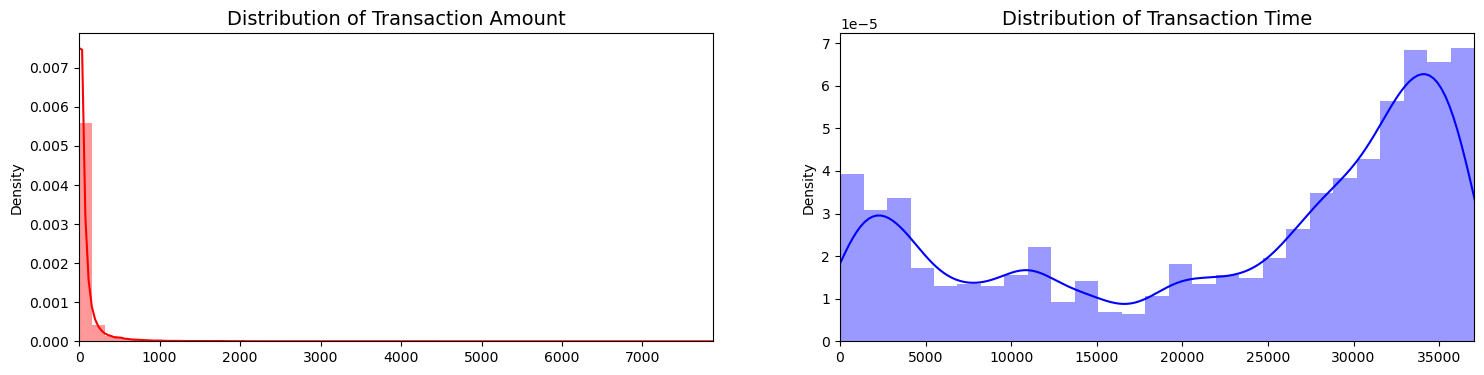

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [91]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [92]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.894331,-1.249496,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.263548,-1.249496,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.258114,-1.249451,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.510721,-1.249451,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.724849,-1.249406,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [93]:
X = df.drop('Class', axis=1)
y = df['Class']

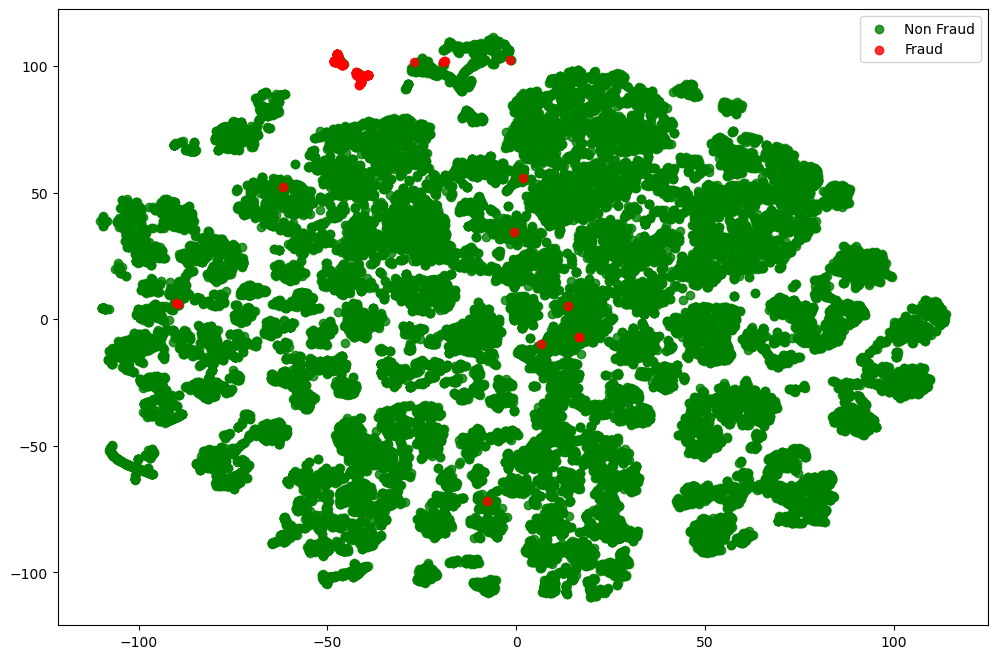

In [98]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    #plt.savefig(name);
    plt.show();
    
tsne_plot(X, y, "original.png")


In [99]:
from imblearn.over_sampling import SMOTE
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy=0.20, random_state=42)
# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(X, y)

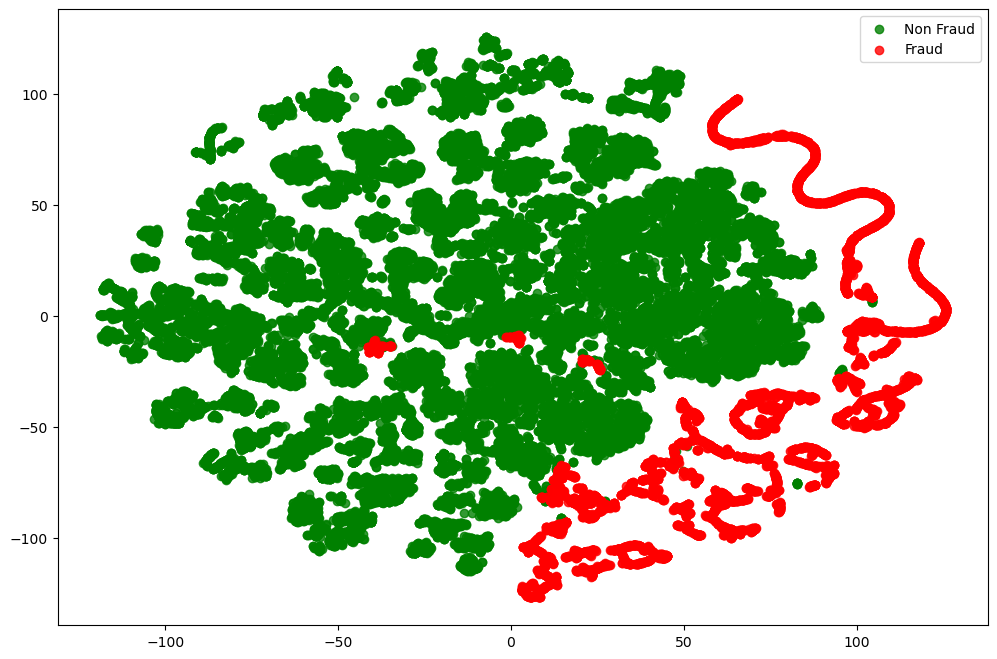

In [101]:
tsne_plot(Xsm_train, ysm_train, "original.png")

In [49]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(Xsm_train, ysm_train, test_size=0.2, random_state=42)

In [76]:
def logistic_regression(X_train, y_train): # Logistic Regression 
    log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
    grid_log_reg.fit(X_train, y_train)
    log_reg = grid_log_reg.best_estimator_ # We automatically get the logistic regression with the best parameters.
    return log_reg

def knn(X_train, y_train): # KNN Classifier
    knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
    grid_knears.fit(X_train, y_train)
    knears_neighbors = grid_knears.best_estimator_ # KNears best estimator
    return knears_neighbors

def svc(X_train, y_train): # Support Vector Classifier
    svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
    grid_svc = GridSearchCV(SVC(), svc_params)
    grid_svc.fit(X_train, y_train)
    svc = grid_svc.best_estimator_ # SVC best estimator
    return svc

def decision_tree(X_train, y_train): # DecisionTree Classifier
    tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4)), "min_samples_leaf": list(range(5,7))}
    grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
    grid_tree.fit(X_train, y_train)
    tree_clf = grid_tree.best_estimator_ # tree best estimator
    return tree_clf

def random_forest(X_train, y_train): # Random Forest Classifier

    pipeline_rf = Pipeline([('model', RandomForestClassifier(n_jobs=-1, random_state=1))])
    rf_params = {'model__n_estimators': [75]}
    MCC_scorer = make_scorer(matthews_corrcoef)
    grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=rf_params, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

    grid_rf.fit(X_train, y_train)
    rf_clf = grid_rf.best_estimator_ # tree best estimator
    return rf_clf


def xgboost(X_train, y_train):
    model = XGBClassifier(random_state=1,eval_metric='logloss')    
    # Type of scoring used to compare parameter combinations
    xgb_param = {'n_estimators': np.arange(50, 150, 50),'scale_pos_weight': [2, 5, 10],'learning_rate': [0.01, 0.1, 0.2, 0.05],
                    'gamma': [0, 1, 3, 5],'subsample': [0.8, 0.9, 1],'max_depth': np.arange(1, 5, 1),'reg_lambda': [5, 10]}
    scorer = make_scorer(recall_score)
    grid_xgb = GridSearchCV(estimator=model, param_grid=xgb_param, scoring=scorer, cv=5, n_jobs = -1)
    grid_xgb.fit(X_train, y_train)
    xgb_clf = grid_xgb.best_estimator_ # tree best estimator
    return xgb_clf

###  Model Execution:

In [77]:
def model_execution(classifiers, X_train, y_train):
    for model in classifiers:
        if classifiers[model]['output'] is None:
            print("Excuting... " + model)
            classifiers[model]['output'] = classifiers[model]['function'](X_train, y_train)
            print(model + "Execution Done.")

###  Model Evaluation:

In [78]:
def model_evaluation(classifiers, X_test, y_test):
    # Defining number of columns
    n_cols, n_models = 3, len(classifiers)
    n_rows = math.ceil(n_models/n_cols)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(21, 7*n_rows))

    i, j = 0, 0
    for model in classifiers:
        y_pred = classifiers[model]['output'].predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp = disp.plot(include_values=True, cmap='Blues', ax=ax[i, j])
        disp.ax_.set_title('Confusion Matrix')
    
        # Generate report
        report = classification_report(y_test, y_pred)
        
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{model} Classification Report')
        ax[i, j].annotate(report, xy=(0.1, 0), xytext=(0, -10), xycoords='axes fraction', textcoords='offset pixels', va='top')

        
        if j==n_cols-1: j, i = 0, i+1
        else: j+=1
    
    plt.subplots_adjust(hspace=0.5)
    # plt.subplot_tool()
    plt.show()

In [81]:
classifiers = {
    "Logisitic Regression": {'function': logistic_regression, 'output': None},
    "KNearest": {'function': knn, 'output': None},
    "Support Vector Classifier": {'function': svc, 'output': None},
    "DecisionTree Classifier": {'function': decision_tree, 'output': None},
    "RandomForest Classifier": {'function': random_forest, 'output': None},
    "XGBoost Classifier": {'function': xgboost, 'output': None}
}

In [82]:
model_execution(classifiers, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
model_evaluation(classifiers, X_test, y_test)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

In [ ]:
def graph_roc_curve_multiple():
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    
    for model in classifiers:
        model_pred = cross_val_predict(classifiers[model]['output'], X_train, y_train, cv=10)
        log_fpr, log_tpr, log_thresold = roc_curve(y_train, model_pred)
        plt.plot(log_fpr, log_tpr, label=model+' Score: {:.4f}'.format(roc_auc_score(y_train, model_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()
    
graph_roc_curve_multiple()
plt.show()

In [9]:
import os
import pandas as pd
import dill

def load_object(file_path):
    with open(file_path, "rb") as file_obj:
        return dill.load(file_obj)

In [45]:
model_folder_path: str = os.path.join('/Users/keval_78/Keval/Data Science/Loyalist/Term 4/AIP/Credit-Card-Fraud-Detection/artifacts', "models")
models = {
    "LogisiticRegression": [],
    "KNearest": [],
    "SupportVectorClassifier": [],
    "DecisionTreeClassifier": [],
    "RandomForestClassifier": [],
    "XGBoostClassifier": []
}
test_data_path: str = os.path.join('/Users/keval_78/Keval/Data Science/Loyalist/Term 4/AIP/Credit-Card-Fraud-Detection/artifacts', "test.csv")
df = pd.read_csv(test_data_path)

for model in models:
    model_path = os.path.join(model_folder_path, "{}.pkl".format(model))
    ml_model = load_object(file_path=model_path)
    index_no = 144
    data_input = [df.iloc[index_no][df.columns[:-1]].to_list()]
    preds=ml_model.predict(data_input)
    class_val = "Fraud" if preds[0] == 1 else "Non-Fraud"
    print("Prediction for {} is: {}".format(model, class_val))
    

Prediction for LogisiticRegression is: Non-Fraud
Prediction for KNearest is: Non-Fraud
Prediction for SupportVectorClassifier is: Non-Fraud
Prediction for DecisionTreeClassifier is: Fraud
Prediction for RandomForestClassifier is: Fraud
Prediction for XGBoostClassifier is: Fraud
